In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tfrecorder import TFrecorder
import struct
import os
import subprocess
from subprocess import check_output
import scipy.io.wavfile as wav
PATH = '/USERS/d8182103/'
tfr = TFrecorder()
Model = tf.keras.models

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def path_list(dataset='V2',setname='train',feature_type = 'mfcc'):
    audio_feature_path = '%s/firstimpression%s/%s/%s/' %(PATH, dataset, feature_type, setname)
    print(audio_feature_path)
    video_list = []
    path_list = []
    for folder in os.listdir(audio_feature_path):
        if '80_' in folder:
            for feature in os.listdir('%s/%s/' %(audio_feature_path,folder)):
                if '.htk' in feature:
                    video_list.append(feature.split('.htk')[0])
                    path_list.append('%s/%s/%s' %(audio_feature_path,folder,feature))
    path_df = pd.DataFrame({'video':video_list,'path':path_list},columns=['video','path'])
    return path_df.set_index('video')
def get_dataframe(df,dataset,setname):
    # read file containing the video name that will not be used
    delete_list = PATH+('firstimpression%s/tfrecord/text/%s/%s_videos_without_transcription.txt' %(dataset,setname,setname))
    if dataset =='V2':
        df = df.drop(columns=['text'])
    try:
        with open(delete_list,'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print('firstimpression V1')
    else:
        # get indexes that should be removed from datafram
        remove_indexes = []
        for l in lines:
            remove_indexes.append(df[df['video']==l[:-1]].index[0])
        # drop rows of those indexes
        df = df.drop(np.array(remove_indexes))
    return df
def create_parser(data_info, retrieve_shape):

    names = data_info['name']
    types = data_info['type']
    shapes = data_info['shape']
    isbytes = data_info['isbyte']
    defaults = data_info['default']
    length_types = data_info['length_type']

    def parser(example_proto):
        def specify_features():
            specified_features = {}
            for i in np.arange(len(names)):
                # which type
                if isbytes[i]:
                    t = tf.string
                    s = ()
                else:
                    if types[i]=='uint8':
                        types[i]=tf.uint8
                    t = types[i]
                    s = shapes[i]
                # has default_value?
                if defaults[i] == np.NaN:
                    d = np.NaN
                else:
                    d = defaults[i]
                # length varies
                if length_types[i] =='fixed':
                    specified_features[names[i]] = tf.FixedLenFeature(s, t)
                elif length_types[i] =='var':
                    specified_features[names[i]] = tf.VarLenFeature(t)
                else:
                    raise TypeError("length_type is not one of 'var', 'fixed'")
            return specified_features


        # decode each parsed feature and reshape
        def decode_reshape():
            # store all decoded&shaped features
            final_features = {}
            for i in np.arange(len(names)):
                # exclude shape info
                if '_shape' not in names[i]:
                    # decode
                    if isbytes[i]:
                        # from byte format
                        decoded_value = tf.decode_raw(parsed_example[names[i]], types[i])
                        decoded_value = tf.cast(decoded_value, tf.float32)
                    else:
                        # Varlen value needs to be converted to dense format
                        if length_types[i] == 'var':
                            decoded_value = tf.sparse_tensor_to_dense(parsed_example[names[i]])
                        else:
                            decoded_value = parsed_example[names[i]]
                    # reshape
                    if '%s_shape' %names[i] in parsed_example.keys():
                        tf_shape = parsed_example['%s_shape' %names[i]]
                        decoded_value = tf.reshape(decoded_value, tf_shape)
                    final_features[names[i]] = decoded_value
                elif retrieve_shape:
                    final_features[names[i]] = parsed_example[names[i]]
            return final_features


        # create a dictionary to specify how to parse each feature 
        specified_features = specify_features()
        # parse all features of an example
        parsed_example = tf.parse_single_example(example_proto, specified_features)
        final_features = decode_reshape()

        return final_features
    return parser


def get_dataset(paths, data_info, retrieve_shape = False, num_parallel_calls=4, prefetch_buffer=2):

    filenames = paths
    
    data_info = pd.read_csv(data_info,dtype={'isbyte':bool})
    data_info['shape']=data_info['shape'].apply(lambda s: [int(i) for i in s[1:-1].split(',') if i !=''])

    #print(data_info)
    dataset = tf.data.TFRecordDataset(filenames)
    parse_function = create_parser(data_info, retrieve_shape)
    dataset = dataset.map(parse_function, num_parallel_calls=num_parallel_calls).prefetch(prefetch_buffer)
    return dataset

In [3]:
sess=tf.InteractiveSession()

In [4]:
VGG19 = tf.keras.applications.VGG19(
                    include_top=None,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=(180, 320, 3),
                    pooling=None,
                    classes=1000
                    )

In [5]:
VGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 160, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 160, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 80, 128)       0         
__________

In [6]:
feature_name = 'VGG_block1_conv1_gram'
def save_audio_feature(dataset,setname):
    # read dataframe
    #df = pd.read_csv(PATH+'firstimpression%s/%s/text_and_labels.csv' %(dataset,setname))
    # get correct df
    #video_df = get_dataframe(df,dataset, setname)
    #path_df = path_wav_list(dataset=dataset,setname=setname)
    # read dataframe
    VGG19 = tf.keras.applications.VGG19(
                    include_top=None,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=(180, 320, 3),
                    pooling=None,
                    classes=1000
                    )
    model = Model.Model(inputs=VGG19.input, outputs=VGG19.get_layer('block1_conv2').output)
    df = pd.read_csv(PATH+'firstimpression%s/%s/text_and_labels.csv' %(dataset,setname))
    # get correct df
    video_df = get_dataframe(df,dataset, setname)

    num_examples = len(video_df)
    
    datapath = '/USERS/d8182103/'
    modalities = ['images']
    videoshape= [-1,180,320,3]
    videofeature='320x180'
    video_padding_info = {videofeature:videoshape}
    video_padding_value = {videofeature:0.0}
    video_info_path = '%s/firstimpression%s/tfrecord/images/%s.csv' %(datapath,dataset, videofeature)
    video_dataset_path = '%s/firstimpression%s/tfrecord/images/%s/%s.tfrecord' %(datapath, dataset, setname, videofeature)
    video_dataset = get_dataset(paths=video_dataset_path, data_info=video_info_path,  num_parallel_calls=1, prefetch_buffer=1)
    iterator = video_dataset.make_one_shot_iterator()
    example = iterator.get_next()
    return example
    data_info = pd.DataFrame({'name':[feature_name,feature_name+'_shape'],
                                 'type':['float32','int64'],
                                 'shape':[(2080,),(2,)],
                                 'isbyte':[True,False],
                                 "length_type":['fixed','fixed'],
                                 "default":[np.NaN,np.NaN]})

    data_info_path = PATH+'firstimpression%s/tfrecord/images/%s.csv' %(dataset,feature_name)
    data_info.to_csv(data_info_path,index=False)
    
    tfr = TFrecorder()
    writer = tf.python_io.TFRecordWriter(PATH+'firstimpression%s/tfrecord/images/%s/%s.tfrecord' %(dataset,setname,feature_name))
    #featuredata = np.load(PATH+'firstimpression%s/image_320x180/face_%s.npy' %(dataset,setname))
    #mean,std = np.load(PATH+'firstimpression%s/image_320x180/face_mean_std.npy' %(dataset))
    for i in np.arange(num_examples):
        features = {}
        
        #video = video_df.iloc[i]['video'].split('.mp4')[0]
        #wav_path = path_df.loc[video]['path']
        #mfcc_file_name = PATH+'firstimpression%s/mfcc_dir/%s/%s.mfc' %(dataset,setname,video) #path_df.loc[video]['path']
        out = model.predict(tf.keras.applications.inception_v3.preprocess_input(example['320x180'].eval()))
        #goodinputs = tf.keras.applications.inception_v3.preprocess_input(inputs)
        out = out.reshape((-1,180*320,64))
        out = np.array([np.hstack([x[i:] for i,x in enumerate(np.dot(o.T,o))]) for o in out])
        #audio_features = read_htk(mfcc_file_name)[0]
        #audio_features = fb_extractor(wav_path)
        #audio_features = np.array(audio_features,dtype='float32')
        #print(audio_features.shape)
        out = (out-out.mean())/out.std()
        #sentence_based_norm = np.array(sentence_based_norm,dtype='float32')
        
        #featuredata[i] = (featuredata[i]-mean)/std
        #print(featuredata[i].mean(),featuredata[i].std(),featuredata[i].shape)
        print(out.shape)
        tfr.feature_writer(data_info.iloc[0], out.reshape(-1).astype('float32'), features)
        tfr.feature_writer(data_info.iloc[1], out.shape, features)
        
        tf_features = tf.train.Features(feature= features)
        tf_example = tf.train.Example(features = tf_features)
        tf_serialized = tf_example.SerializeToString()
        writer.write(tf_serialized)
        print(i)
        
    writer.close()

In [7]:
E =save_audio_feature('V2','vali')

In [13]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
def shows(i):
    imshow(i)
    print(i.shape)

In [29]:
import cv2 as cv
import numpy as np

In [55]:
def flowimages(ims):
    ims = ims.astype(np.uint8)
    hsv = np.zeros_like(ims[0])
    hsv[...,1] = 255
    def flow2(i1,i2):
        frame1 = cv.cvtColor(i1,cv.COLOR_BGR2GRAY)
        frame2 = cv.cvtColor(i2,cv.COLOR_BGR2GRAY)
        flow = cv.calcOpticalFlowFarneback(frame1,frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
        bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
        return bgr
    num = ims.shape[0]
    tensors=[]
    for i in range(0,num-1):
        tensors.append(flow2(ims[i],ims[i+1]))
    return tensors

In [56]:
A = flowimages(a)

In [59]:
len(A)

154

(180, 320, 3)


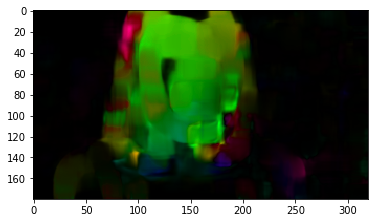

In [62]:
shows(A[10])

In [ ]:
for dataset in ['V2']:
    for setname in ['train','vali','test']:
        save_audio_feature(dataset,setname)
        print(dataset,setname)

(155, 2080)
0
(155, 2080)
1
(155, 2080)
2
(155, 2080)
3
(155, 2080)
4
(155, 2080)
5
(155, 2080)
6
(155, 2080)
7
(155, 2080)
8
(155, 2080)
9
(155, 2080)
10
(155, 2080)
11
(155, 2080)
12
(155, 2080)
13
(155, 2080)
14
(155, 2080)
15
(155, 2080)
16
(155, 2080)
17
(155, 2080)
18
(155, 2080)
19
(155, 2080)
20
(155, 2080)
21
(155, 2080)
22
(155, 2080)
23
(155, 2080)
24
(155, 2080)
25
(155, 2080)
26
(155, 2080)
27
(156, 2080)
28
(155, 2080)
29
(155, 2080)
30
(155, 2080)
31
(155, 2080)
32
(155, 2080)
33
(155, 2080)
34
(155, 2080)
35
(155, 2080)
36
(155, 2080)
37
(155, 2080)
38
(155, 2080)
39
(155, 2080)
40
(155, 2080)
41
(155, 2080)
42
(155, 2080)
43
(155, 2080)
44
(155, 2080)
45
(155, 2080)
46
(155, 2080)
47
(155, 2080)
48
(155, 2080)
49
(155, 2080)
50
(155, 2080)
51
(155, 2080)
52
(155, 2080)
53
(155, 2080)
54
(155, 2080)
55
(155, 2080)
56
(155, 2080)
57
(155, 2080)
58
(155, 2080)
59
(155, 2080)
60
(155, 2080)
61
(155, 2080)
62
(155, 2080)
63
(155, 2080)
64
(155, 2080)
65
(155, 2080)
66
(155,

(155, 2080)
519
(155, 2080)
520
(155, 2080)
521
(155, 2080)
522
(155, 2080)
523
(155, 2080)
524
(155, 2080)
525
(155, 2080)
526
(155, 2080)
527
(155, 2080)
528
(155, 2080)
529
(155, 2080)
530
(155, 2080)
531
(155, 2080)
532
(155, 2080)
533
(155, 2080)
534
(155, 2080)
535
(155, 2080)
536
(155, 2080)
537
(155, 2080)
538
(155, 2080)
539
(155, 2080)
540
(155, 2080)
541
(155, 2080)
542
(155, 2080)
543
(155, 2080)
544
(155, 2080)
545
(155, 2080)
546
(155, 2080)
547
(155, 2080)
548
(155, 2080)
549
(155, 2080)
550
(155, 2080)
551
(155, 2080)
552
(155, 2080)
553
(155, 2080)
554
(155, 2080)
555
(155, 2080)
556
(155, 2080)
557
(155, 2080)
558
(155, 2080)
559
(155, 2080)
560
(155, 2080)
561
(155, 2080)
562
(155, 2080)
563
(155, 2080)
564
(155, 2080)
565
(155, 2080)
566
(155, 2080)
567
(155, 2080)
568
(155, 2080)
569
(155, 2080)
570
(155, 2080)
571
(155, 2080)
572
(155, 2080)
573
(155, 2080)
574
(155, 2080)
575
(155, 2080)
576
(155, 2080)
577
(155, 2080)
578
(155, 2080)
579
(155, 2080)
580
(155, 20

(155, 2080)
1030
(155, 2080)
1031
(155, 2080)
1032
(155, 2080)
1033
(155, 2080)
1034
(155, 2080)
1035
(155, 2080)
1036
(155, 2080)
1037
(155, 2080)
1038
(155, 2080)
1039
(155, 2080)
1040
(155, 2080)
1041
(155, 2080)
1042
(155, 2080)
1043
(155, 2080)
1044
(155, 2080)
1045
(155, 2080)
1046
(155, 2080)
1047
(155, 2080)
1048
(155, 2080)
1049
(155, 2080)
1050
(155, 2080)
1051
(155, 2080)
1052
(155, 2080)
1053
(155, 2080)
1054
(155, 2080)
1055
(155, 2080)
1056
(155, 2080)
1057
(155, 2080)
1058
(155, 2080)
1059
(155, 2080)
1060
(155, 2080)
1061
(155, 2080)
1062
(155, 2080)
1063
(155, 2080)
1064
(155, 2080)
1065
(155, 2080)
1066
(155, 2080)
1067
(155, 2080)
1068
(155, 2080)
1069
(155, 2080)
1070
(155, 2080)
1071
(155, 2080)
1072
(155, 2080)
1073
(155, 2080)
1074
(155, 2080)
1075
(155, 2080)
1076
(155, 2080)
1077
(155, 2080)
1078
(155, 2080)
1079
(155, 2080)
1080
(155, 2080)
1081
(155, 2080)
1082
(155, 2080)
1083
(155, 2080)
1084
(155, 2080)
1085
(155, 2080)
1086
(155, 2080)
1087
(155, 2080)
10

(155, 2080)
1512
(155, 2080)
1513
(155, 2080)
1514
(155, 2080)
1515
(155, 2080)
1516
(155, 2080)
1517
(155, 2080)
1518
(155, 2080)
1519
(155, 2080)
1520
(155, 2080)
1521
(155, 2080)
1522
(155, 2080)
1523
(155, 2080)
1524
(155, 2080)
1525
(155, 2080)
1526
(155, 2080)
1527
(155, 2080)
1528
(155, 2080)
1529
(155, 2080)
1530
(155, 2080)
1531
(155, 2080)
1532
(155, 2080)
1533
(155, 2080)
1534
(155, 2080)
1535
(155, 2080)
1536
(155, 2080)
1537
(155, 2080)
1538
(155, 2080)
1539
(155, 2080)
1540
(155, 2080)
1541
(155, 2080)
1542
(155, 2080)
1543
(155, 2080)
1544
(155, 2080)
1545
(155, 2080)
1546
(155, 2080)
1547
(155, 2080)
1548
(155, 2080)
1549
(155, 2080)
1550
(155, 2080)
1551
(155, 2080)
1552
(155, 2080)
1553
(155, 2080)
1554
(155, 2080)
1555
(155, 2080)
1556
(155, 2080)
1557
(155, 2080)
1558
(155, 2080)
1559
(124, 2080)
1560
(155, 2080)
1561
(155, 2080)
1562
(155, 2080)
1563
(155, 2080)
1564
(155, 2080)
1565
(155, 2080)
1566
(155, 2080)
1567
(155, 2080)
1568
(155, 2080)
1569
(155, 2080)
15

(155, 2080)
1994
(155, 2080)
1995
(155, 2080)
1996
(155, 2080)
1997
(155, 2080)
1998
(155, 2080)
1999
(155, 2080)
2000
(155, 2080)
2001
(155, 2080)
2002
(155, 2080)
2003
(156, 2080)
2004
(155, 2080)
2005
(155, 2080)
2006
(155, 2080)
2007
(155, 2080)
2008
(155, 2080)
2009
(155, 2080)
2010
(155, 2080)
2011
(155, 2080)
2012
(155, 2080)
2013
(155, 2080)
2014
(155, 2080)
2015
(155, 2080)
2016
(155, 2080)
2017
(155, 2080)
2018
(155, 2080)
2019
(155, 2080)
2020
(153, 2080)
2021
(155, 2080)
2022
(155, 2080)
2023
(155, 2080)
2024
(155, 2080)
2025
(155, 2080)
2026
(155, 2080)
2027
(155, 2080)
2028
(155, 2080)
2029
(155, 2080)
2030
(155, 2080)
2031
(155, 2080)
2032
(155, 2080)
2033
(155, 2080)
2034
(155, 2080)
2035
(155, 2080)
2036
(155, 2080)
2037
(155, 2080)
2038
(155, 2080)
2039
(155, 2080)
2040
(155, 2080)
2041
(155, 2080)
2042
(155, 2080)
2043
(155, 2080)
2044
(155, 2080)
2045
(155, 2080)
2046
(155, 2080)
2047
(155, 2080)
2048
(155, 2080)
2049
(155, 2080)
2050
(155, 2080)
2051
(155, 2080)
20

In [ ]:
for dataset in ['V1']:
    for setname in ['train','vali']:
        save_audio_feature(dataset,setname)
        print(dataset,setname)

firstimpression V1
(155, 4, 8, 1280)
0
(155, 4, 8, 1280)
1
(155, 4, 8, 1280)
2
(155, 4, 8, 1280)
3
(155, 4, 8, 1280)
4
(155, 4, 8, 1280)
5
(155, 4, 8, 1280)
6
(155, 4, 8, 1280)
7
(155, 4, 8, 1280)
8
(155, 4, 8, 1280)
9
(155, 4, 8, 1280)
10
(155, 4, 8, 1280)
11
(155, 4, 8, 1280)
12
(155, 4, 8, 1280)
13
(155, 4, 8, 1280)
14
(155, 4, 8, 1280)
15
(155, 4, 8, 1280)
16
(155, 4, 8, 1280)
17
(155, 4, 8, 1280)
18
(155, 4, 8, 1280)
19
(155, 4, 8, 1280)
20
(155, 4, 8, 1280)
21
(155, 4, 8, 1280)
22
(155, 4, 8, 1280)
23
(155, 4, 8, 1280)
24
(155, 4, 8, 1280)
25
(155, 4, 8, 1280)
26
(155, 4, 8, 1280)
27
(156, 4, 8, 1280)
28
(155, 4, 8, 1280)
29
(155, 4, 8, 1280)
30
(155, 4, 8, 1280)
31
(155, 4, 8, 1280)
32
(155, 4, 8, 1280)
33
(155, 4, 8, 1280)
34
(155, 4, 8, 1280)
35
(155, 4, 8, 1280)
36
(155, 4, 8, 1280)
37
(155, 4, 8, 1280)
38
(155, 4, 8, 1280)
39
(155, 4, 8, 1280)
40
(155, 4, 8, 1280)
41
(155, 4, 8, 1280)
42
(155, 4, 8, 1280)
43
(155, 4, 8, 1280)
44
(155, 4, 8, 1280)
45
(155, 4, 8, 1280)
46
(155

(155, 4, 8, 1280)
377
(155, 4, 8, 1280)
378
(155, 4, 8, 1280)
379
(155, 4, 8, 1280)
380
(155, 4, 8, 1280)
381
(155, 4, 8, 1280)
382
(155, 4, 8, 1280)
383
(155, 4, 8, 1280)
384
(155, 4, 8, 1280)
385
(155, 4, 8, 1280)
386
(155, 4, 8, 1280)
387
(155, 4, 8, 1280)
388
(155, 4, 8, 1280)
389
(155, 4, 8, 1280)
390
(155, 4, 8, 1280)
391
(155, 4, 8, 1280)
392
(155, 4, 8, 1280)
393
(155, 4, 8, 1280)
394
(155, 4, 8, 1280)
395
(155, 4, 8, 1280)
396
(155, 4, 8, 1280)
397
(155, 4, 8, 1280)
398
(155, 4, 8, 1280)
399
(155, 4, 8, 1280)
400
(155, 4, 8, 1280)
401
(155, 4, 8, 1280)
402
(155, 4, 8, 1280)
403
(155, 4, 8, 1280)
404
(155, 4, 8, 1280)
405
(155, 4, 8, 1280)
406
(155, 4, 8, 1280)
407
(155, 4, 8, 1280)
408
(155, 4, 8, 1280)
409
(155, 4, 8, 1280)
410
(155, 4, 8, 1280)
411
(155, 4, 8, 1280)
412
(155, 4, 8, 1280)
413
(155, 4, 8, 1280)
414
(155, 4, 8, 1280)
415
(155, 4, 8, 1280)
416
(155, 4, 8, 1280)
417
(155, 4, 8, 1280)
418
(155, 4, 8, 1280)
419
(155, 4, 8, 1280)
420
(155, 4, 8, 1280)
421
(155, 4, 8

(155, 4, 8, 1280)
750
(155, 4, 8, 1280)
751
(155, 4, 8, 1280)
752
(155, 4, 8, 1280)
753
(155, 4, 8, 1280)
754
(155, 4, 8, 1280)
755
(155, 4, 8, 1280)
756
(155, 4, 8, 1280)
757
(155, 4, 8, 1280)
758
(155, 4, 8, 1280)
759
(155, 4, 8, 1280)
760
(155, 4, 8, 1280)
761
(155, 4, 8, 1280)
762
(155, 4, 8, 1280)
763
(155, 4, 8, 1280)
764
(155, 4, 8, 1280)
765
(155, 4, 8, 1280)
766
(155, 4, 8, 1280)
767
(155, 4, 8, 1280)
768
(155, 4, 8, 1280)
769
(155, 4, 8, 1280)
770
(155, 4, 8, 1280)
771
(155, 4, 8, 1280)
772
(155, 4, 8, 1280)
773
(155, 4, 8, 1280)
774
(155, 4, 8, 1280)
775
(155, 4, 8, 1280)
776
(155, 4, 8, 1280)
777
(155, 4, 8, 1280)
778
(155, 4, 8, 1280)
779
(155, 4, 8, 1280)
780
(155, 4, 8, 1280)
781
(156, 4, 8, 1280)
782
(155, 4, 8, 1280)
783
(155, 4, 8, 1280)
784
(155, 4, 8, 1280)
785
(155, 4, 8, 1280)
786
(155, 4, 8, 1280)
787
(155, 4, 8, 1280)
788
(155, 4, 8, 1280)
789
(155, 4, 8, 1280)
790
(155, 4, 8, 1280)
791
(155, 4, 8, 1280)
792
(155, 4, 8, 1280)
793
(155, 4, 8, 1280)
794
(155, 4, 8

(155, 4, 8, 1280)
1118
(155, 4, 8, 1280)
1119
(155, 4, 8, 1280)
1120
(155, 4, 8, 1280)
1121
(155, 4, 8, 1280)
1122
(155, 4, 8, 1280)
1123
(155, 4, 8, 1280)
1124
(155, 4, 8, 1280)
1125
(155, 4, 8, 1280)
1126
(155, 4, 8, 1280)
1127
(155, 4, 8, 1280)
1128
(155, 4, 8, 1280)
1129
(155, 4, 8, 1280)
1130
(155, 4, 8, 1280)
1131
(155, 4, 8, 1280)
1132
(155, 4, 8, 1280)
1133
(155, 4, 8, 1280)
1134
(155, 4, 8, 1280)
1135
(155, 4, 8, 1280)
1136
(155, 4, 8, 1280)
1137
(155, 4, 8, 1280)
1138
(155, 4, 8, 1280)
1139
(155, 4, 8, 1280)
1140
(155, 4, 8, 1280)
1141
(155, 4, 8, 1280)
1142
(155, 4, 8, 1280)
1143
(155, 4, 8, 1280)
1144
(155, 4, 8, 1280)
1145
(155, 4, 8, 1280)
1146
(155, 4, 8, 1280)
1147
(156, 4, 8, 1280)
1148
(155, 4, 8, 1280)
1149
(155, 4, 8, 1280)
1150
(155, 4, 8, 1280)
1151
(155, 4, 8, 1280)
1152
(155, 4, 8, 1280)
1153
(155, 4, 8, 1280)
1154
(155, 4, 8, 1280)
1155
(155, 4, 8, 1280)
1156
(155, 4, 8, 1280)
1157
(155, 4, 8, 1280)
1158
(155, 4, 8, 1280)
1159
(155, 4, 8, 1280)
1160
(155, 4, 8,

(155, 4, 8, 1280)
1475
(155, 4, 8, 1280)
1476
(155, 4, 8, 1280)
1477
(156, 4, 8, 1280)
1478
(155, 4, 8, 1280)
1479
(155, 4, 8, 1280)
1480
(155, 4, 8, 1280)
1481
(155, 4, 8, 1280)
1482
(155, 4, 8, 1280)
1483
(155, 4, 8, 1280)
1484
(155, 4, 8, 1280)
1485
(155, 4, 8, 1280)
1486
(155, 4, 8, 1280)
1487
(155, 4, 8, 1280)
1488
(155, 4, 8, 1280)
1489
(155, 4, 8, 1280)
1490
(155, 4, 8, 1280)
1491
(155, 4, 8, 1280)
1492
(155, 4, 8, 1280)
1493
(155, 4, 8, 1280)
1494
(155, 4, 8, 1280)
1495
(155, 4, 8, 1280)
1496
(155, 4, 8, 1280)
1497
(155, 4, 8, 1280)
1498
(155, 4, 8, 1280)
1499
(155, 4, 8, 1280)
1500
(155, 4, 8, 1280)
1501
(155, 4, 8, 1280)
1502
(155, 4, 8, 1280)
1503
(155, 4, 8, 1280)
1504
(155, 4, 8, 1280)
1505
(155, 4, 8, 1280)
1506
(155, 4, 8, 1280)
1507
(155, 4, 8, 1280)
1508
(155, 4, 8, 1280)
1509
(155, 4, 8, 1280)
1510
(155, 4, 8, 1280)
1511
(155, 4, 8, 1280)
1512
(155, 4, 8, 1280)
1513
(155, 4, 8, 1280)
1514
(155, 4, 8, 1280)
1515
(155, 4, 8, 1280)
1516
(155, 4, 8, 1280)
1517
(155, 4, 8,

(155, 4, 8, 1280)
1832
(155, 4, 8, 1280)
1833
(155, 4, 8, 1280)
1834
(155, 4, 8, 1280)
1835
(155, 4, 8, 1280)
1836
(155, 4, 8, 1280)
1837
(155, 4, 8, 1280)
1838
(155, 4, 8, 1280)
1839
(155, 4, 8, 1280)
1840
(155, 4, 8, 1280)
1841
(154, 4, 8, 1280)
1842
(155, 4, 8, 1280)
1843
(155, 4, 8, 1280)
1844
(155, 4, 8, 1280)
1845
(155, 4, 8, 1280)
1846
(155, 4, 8, 1280)
1847
(155, 4, 8, 1280)
1848
(155, 4, 8, 1280)
1849
(155, 4, 8, 1280)
1850
(155, 4, 8, 1280)
1851
(155, 4, 8, 1280)
1852
(155, 4, 8, 1280)
1853
(155, 4, 8, 1280)
1854
(155, 4, 8, 1280)
1855
(155, 4, 8, 1280)
1856
(155, 4, 8, 1280)
1857
(155, 4, 8, 1280)
1858
(155, 4, 8, 1280)
1859
(155, 4, 8, 1280)
1860
(155, 4, 8, 1280)
1861
(155, 4, 8, 1280)
1862
(155, 4, 8, 1280)
1863
(155, 4, 8, 1280)
1864
(155, 4, 8, 1280)
1865
(155, 4, 8, 1280)
1866
(155, 4, 8, 1280)
1867
(155, 4, 8, 1280)
1868
(155, 4, 8, 1280)
1869
(155, 4, 8, 1280)
1870
(155, 4, 8, 1280)
1871
(155, 4, 8, 1280)
1872
(155, 4, 8, 1280)
1873
(155, 4, 8, 1280)
1874
(155, 4, 8,

(155, 4, 8, 1280)
2189
(155, 4, 8, 1280)
2190
(155, 4, 8, 1280)
2191
(155, 4, 8, 1280)
2192
(155, 4, 8, 1280)
2193
(155, 4, 8, 1280)
2194
(155, 4, 8, 1280)
2195
(155, 4, 8, 1280)
2196
(155, 4, 8, 1280)
2197
(155, 4, 8, 1280)
2198
(155, 4, 8, 1280)
2199
(155, 4, 8, 1280)
2200
(155, 4, 8, 1280)
2201
(155, 4, 8, 1280)
2202
(155, 4, 8, 1280)
2203
(155, 4, 8, 1280)
2204
(155, 4, 8, 1280)
2205
(155, 4, 8, 1280)
2206
(155, 4, 8, 1280)
2207
(155, 4, 8, 1280)
2208
(155, 4, 8, 1280)
2209
(155, 4, 8, 1280)
2210
(155, 4, 8, 1280)
2211
(155, 4, 8, 1280)
2212
(155, 4, 8, 1280)
2213
(155, 4, 8, 1280)
2214
(155, 4, 8, 1280)
2215
(155, 4, 8, 1280)
2216
(155, 4, 8, 1280)
2217
(155, 4, 8, 1280)
2218
(155, 4, 8, 1280)
2219
(155, 4, 8, 1280)
2220
(155, 4, 8, 1280)
2221
(155, 4, 8, 1280)
2222
(155, 4, 8, 1280)
2223
(155, 4, 8, 1280)
2224
(155, 4, 8, 1280)
2225
(155, 4, 8, 1280)
2226
(155, 4, 8, 1280)
2227
(155, 4, 8, 1280)
2228
(155, 4, 8, 1280)
2229
(155, 4, 8, 1280)
2230
(155, 4, 8, 1280)
2231
(155, 4, 8,

(155, 4, 8, 1280)
2546
(155, 4, 8, 1280)
2547
(155, 4, 8, 1280)
2548
(155, 4, 8, 1280)
2549
(156, 4, 8, 1280)
2550
(155, 4, 8, 1280)
2551
(155, 4, 8, 1280)
2552
(155, 4, 8, 1280)
2553
(155, 4, 8, 1280)
2554
(155, 4, 8, 1280)
2555
(155, 4, 8, 1280)
2556
(155, 4, 8, 1280)
2557
(155, 4, 8, 1280)
2558
(155, 4, 8, 1280)
2559
(155, 4, 8, 1280)
2560
(155, 4, 8, 1280)
2561
(155, 4, 8, 1280)
2562
(155, 4, 8, 1280)
2563
(155, 4, 8, 1280)
2564
(155, 4, 8, 1280)
2565
(155, 4, 8, 1280)
2566
(155, 4, 8, 1280)
2567
(155, 4, 8, 1280)
2568
(155, 4, 8, 1280)
2569
(93, 4, 8, 1280)
2570
(155, 4, 8, 1280)
2571
(155, 4, 8, 1280)
2572
(155, 4, 8, 1280)
2573
(155, 4, 8, 1280)
2574
(155, 4, 8, 1280)
2575
(155, 4, 8, 1280)
2576
(155, 4, 8, 1280)
2577
(155, 4, 8, 1280)
2578
(155, 4, 8, 1280)
2579
(155, 4, 8, 1280)
2580
(155, 4, 8, 1280)
2581
(155, 4, 8, 1280)
2582
(155, 4, 8, 1280)
2583
(155, 4, 8, 1280)
2584
(155, 4, 8, 1280)
2585
(155, 4, 8, 1280)
2586
(155, 4, 8, 1280)
2587
(155, 4, 8, 1280)
2588
(155, 4, 8, 

(155, 4, 8, 1280)
2903
(155, 4, 8, 1280)
2904
(155, 4, 8, 1280)
2905
(155, 4, 8, 1280)
2906
(155, 4, 8, 1280)
2907
(155, 4, 8, 1280)
2908
(155, 4, 8, 1280)
2909
(155, 4, 8, 1280)
2910
(155, 4, 8, 1280)
2911
(155, 4, 8, 1280)
2912
(155, 4, 8, 1280)
2913
(155, 4, 8, 1280)
2914
(155, 4, 8, 1280)
2915
(155, 4, 8, 1280)
2916
(155, 4, 8, 1280)
2917
(155, 4, 8, 1280)
2918
(155, 4, 8, 1280)
2919
(155, 4, 8, 1280)
2920
(155, 4, 8, 1280)
2921
(155, 4, 8, 1280)
2922
(155, 4, 8, 1280)
2923
(155, 4, 8, 1280)
2924
(155, 4, 8, 1280)
2925
(155, 4, 8, 1280)
2926
(155, 4, 8, 1280)
2927
(155, 4, 8, 1280)
2928
(155, 4, 8, 1280)
2929
(155, 4, 8, 1280)
2930
(155, 4, 8, 1280)
2931
(155, 4, 8, 1280)
2932
(155, 4, 8, 1280)
2933
(155, 4, 8, 1280)
2934
(155, 4, 8, 1280)
2935
(155, 4, 8, 1280)
2936
(155, 4, 8, 1280)
2937
(155, 4, 8, 1280)
2938
(155, 4, 8, 1280)
2939
(155, 4, 8, 1280)
2940
(155, 4, 8, 1280)
2941
(155, 4, 8, 1280)
2942
(155, 4, 8, 1280)
2943
(156, 4, 8, 1280)
2944
(155, 4, 8, 1280)
2945
(155, 4, 8,

(155, 4, 8, 1280)
3260
(155, 4, 8, 1280)
3261
(155, 4, 8, 1280)
3262
(155, 4, 8, 1280)
3263
(155, 4, 8, 1280)
3264
(155, 4, 8, 1280)
3265
(155, 4, 8, 1280)
3266
(155, 4, 8, 1280)
3267
(155, 4, 8, 1280)
3268
(155, 4, 8, 1280)
3269
(155, 4, 8, 1280)
3270
(155, 4, 8, 1280)
3271
(155, 4, 8, 1280)
3272
(155, 4, 8, 1280)
3273
(155, 4, 8, 1280)
3274
(155, 4, 8, 1280)
3275
(155, 4, 8, 1280)
3276
(155, 4, 8, 1280)
3277
(155, 4, 8, 1280)
3278
(155, 4, 8, 1280)
3279
(155, 4, 8, 1280)
3280
(156, 4, 8, 1280)
3281
(155, 4, 8, 1280)
3282
(155, 4, 8, 1280)
3283
(155, 4, 8, 1280)
3284
(155, 4, 8, 1280)
3285
(155, 4, 8, 1280)
3286
(155, 4, 8, 1280)
3287
(155, 4, 8, 1280)
3288
(155, 4, 8, 1280)
3289
(155, 4, 8, 1280)
3290
(155, 4, 8, 1280)
3291
(155, 4, 8, 1280)
3292
(155, 4, 8, 1280)
3293
(155, 4, 8, 1280)
3294
(155, 4, 8, 1280)
3295
(155, 4, 8, 1280)
3296
(155, 4, 8, 1280)
3297
(155, 4, 8, 1280)
3298
(155, 4, 8, 1280)
3299
(155, 4, 8, 1280)
3300
(155, 4, 8, 1280)
3301
(155, 4, 8, 1280)
3302
(155, 4, 8,

(155, 4, 8, 1280)
3617
(155, 4, 8, 1280)
3618
(155, 4, 8, 1280)
3619
(155, 4, 8, 1280)
3620
(155, 4, 8, 1280)
3621
(155, 4, 8, 1280)
3622
(155, 4, 8, 1280)
3623
(155, 4, 8, 1280)
3624
(155, 4, 8, 1280)
3625
(155, 4, 8, 1280)
3626
(155, 4, 8, 1280)
3627
(155, 4, 8, 1280)
3628
(155, 4, 8, 1280)
3629
(155, 4, 8, 1280)
3630
(155, 4, 8, 1280)
3631
(155, 4, 8, 1280)
3632
(155, 4, 8, 1280)
3633
(155, 4, 8, 1280)
3634
(155, 4, 8, 1280)
3635
(155, 4, 8, 1280)
3636
(155, 4, 8, 1280)
3637
(155, 4, 8, 1280)
3638
(155, 4, 8, 1280)
3639
(155, 4, 8, 1280)
3640
(155, 4, 8, 1280)
3641
(155, 4, 8, 1280)
3642
(155, 4, 8, 1280)
3643
(155, 4, 8, 1280)
3644
(155, 4, 8, 1280)
3645
(155, 4, 8, 1280)
3646
(155, 4, 8, 1280)
3647
(155, 4, 8, 1280)
3648
(155, 4, 8, 1280)
3649
(155, 4, 8, 1280)
3650
(155, 4, 8, 1280)
3651
(155, 4, 8, 1280)
3652
(155, 4, 8, 1280)
3653
(155, 4, 8, 1280)
3654
(155, 4, 8, 1280)
3655
(155, 4, 8, 1280)
3656
(155, 4, 8, 1280)
3657
(155, 4, 8, 1280)
3658
(155, 4, 8, 1280)
3659
(155, 4, 8,

(155, 4, 8, 1280)
3974
(155, 4, 8, 1280)
3975
(155, 4, 8, 1280)
3976
(155, 4, 8, 1280)
3977
(155, 4, 8, 1280)
3978
(155, 4, 8, 1280)
3979
(155, 4, 8, 1280)
3980
(155, 4, 8, 1280)
3981
(155, 4, 8, 1280)
3982
(155, 4, 8, 1280)
3983
(155, 4, 8, 1280)
3984
(155, 4, 8, 1280)
3985
(155, 4, 8, 1280)
3986
(155, 4, 8, 1280)
3987
(155, 4, 8, 1280)
3988
(155, 4, 8, 1280)
3989
(155, 4, 8, 1280)
3990
(155, 4, 8, 1280)
3991
(155, 4, 8, 1280)
3992
(155, 4, 8, 1280)
3993
(155, 4, 8, 1280)
3994
(155, 4, 8, 1280)
3995
(155, 4, 8, 1280)
3996
(155, 4, 8, 1280)
3997
(155, 4, 8, 1280)
3998
(155, 4, 8, 1280)
3999
(155, 4, 8, 1280)
4000
(155, 4, 8, 1280)
4001
(155, 4, 8, 1280)
4002
(155, 4, 8, 1280)
4003
(155, 4, 8, 1280)
4004
(155, 4, 8, 1280)
4005
(155, 4, 8, 1280)
4006
(155, 4, 8, 1280)
4007
(155, 4, 8, 1280)
4008
(155, 4, 8, 1280)
4009
(155, 4, 8, 1280)
4010
(155, 4, 8, 1280)
4011
(155, 4, 8, 1280)
4012
(155, 4, 8, 1280)
4013
(155, 4, 8, 1280)
4014
(155, 4, 8, 1280)
4015
(155, 4, 8, 1280)
4016
(155, 4, 8,

(155, 4, 8, 1280)
4331
(155, 4, 8, 1280)
4332
(155, 4, 8, 1280)
4333
(155, 4, 8, 1280)
4334
(155, 4, 8, 1280)
4335
(155, 4, 8, 1280)
4336
(155, 4, 8, 1280)
4337
(155, 4, 8, 1280)
4338
(155, 4, 8, 1280)
4339
(155, 4, 8, 1280)
4340
(155, 4, 8, 1280)
4341
(155, 4, 8, 1280)
4342
(155, 4, 8, 1280)
4343
(155, 4, 8, 1280)
4344
(155, 4, 8, 1280)
4345
(155, 4, 8, 1280)
4346
(155, 4, 8, 1280)
4347
(155, 4, 8, 1280)
4348
(155, 4, 8, 1280)
4349
(155, 4, 8, 1280)
4350
(155, 4, 8, 1280)
4351
(155, 4, 8, 1280)
4352
(155, 4, 8, 1280)
4353
(155, 4, 8, 1280)
4354
(152, 4, 8, 1280)
4355
(155, 4, 8, 1280)
4356
(155, 4, 8, 1280)
4357
(155, 4, 8, 1280)
4358
(155, 4, 8, 1280)
4359
(155, 4, 8, 1280)
4360
(155, 4, 8, 1280)
4361
(155, 4, 8, 1280)
4362
(155, 4, 8, 1280)
4363
(155, 4, 8, 1280)
4364
(155, 4, 8, 1280)
4365
(155, 4, 8, 1280)
4366
(155, 4, 8, 1280)
4367
(155, 4, 8, 1280)
4368
(155, 4, 8, 1280)
4369
(155, 4, 8, 1280)
4370
(155, 4, 8, 1280)
4371
(155, 4, 8, 1280)
4372
(155, 4, 8, 1280)
4373
(155, 4, 8,

(155, 4, 8, 1280)
4688
(155, 4, 8, 1280)
4689
(155, 4, 8, 1280)
4690
(155, 4, 8, 1280)
4691
(155, 4, 8, 1280)
4692
(155, 4, 8, 1280)
4693
(155, 4, 8, 1280)
4694
(155, 4, 8, 1280)
4695
(155, 4, 8, 1280)
4696
(155, 4, 8, 1280)
4697
(155, 4, 8, 1280)
4698
(155, 4, 8, 1280)
4699
(155, 4, 8, 1280)
4700
(155, 4, 8, 1280)
4701
(155, 4, 8, 1280)
4702
(155, 4, 8, 1280)
4703
(155, 4, 8, 1280)
4704
(155, 4, 8, 1280)
4705
(155, 4, 8, 1280)
4706
(155, 4, 8, 1280)
4707
(155, 4, 8, 1280)
4708
(155, 4, 8, 1280)
4709
(155, 4, 8, 1280)
4710
(155, 4, 8, 1280)
4711
(155, 4, 8, 1280)
4712
(155, 4, 8, 1280)
4713
(155, 4, 8, 1280)
4714
(155, 4, 8, 1280)
4715
(155, 4, 8, 1280)
4716
(155, 4, 8, 1280)
4717
(155, 4, 8, 1280)
4718
(155, 4, 8, 1280)
4719
(155, 4, 8, 1280)
4720
(155, 4, 8, 1280)
4721
(155, 4, 8, 1280)
4722
(155, 4, 8, 1280)
4723
(155, 4, 8, 1280)
4724
(155, 4, 8, 1280)
4725
(155, 4, 8, 1280)
4726
(155, 4, 8, 1280)
4727
(155, 4, 8, 1280)
4728
(155, 4, 8, 1280)
4729
(155, 4, 8, 1280)
4730
(155, 4, 8,

(155, 4, 8, 1280)
5045
(155, 4, 8, 1280)
5046
(155, 4, 8, 1280)
5047
(155, 4, 8, 1280)
5048
(155, 4, 8, 1280)
5049
(155, 4, 8, 1280)
5050
(155, 4, 8, 1280)
5051
(155, 4, 8, 1280)
5052
(155, 4, 8, 1280)
5053
(155, 4, 8, 1280)
5054
(155, 4, 8, 1280)
5055
(155, 4, 8, 1280)
5056
(155, 4, 8, 1280)
5057
(155, 4, 8, 1280)
5058
(155, 4, 8, 1280)
5059
(155, 4, 8, 1280)
5060
(156, 4, 8, 1280)
5061
(155, 4, 8, 1280)
5062
(155, 4, 8, 1280)
5063
(155, 4, 8, 1280)
5064
(155, 4, 8, 1280)
5065
(155, 4, 8, 1280)
5066
(155, 4, 8, 1280)
5067
(155, 4, 8, 1280)
5068
(155, 4, 8, 1280)
5069
(155, 4, 8, 1280)
5070
(155, 4, 8, 1280)
5071
(156, 4, 8, 1280)
5072
(155, 4, 8, 1280)
5073
(155, 4, 8, 1280)
5074
(155, 4, 8, 1280)
5075
(155, 4, 8, 1280)
5076
(155, 4, 8, 1280)
5077
(155, 4, 8, 1280)
5078
(155, 4, 8, 1280)
5079
(155, 4, 8, 1280)
5080
(155, 4, 8, 1280)
5081
(155, 4, 8, 1280)
5082
(155, 4, 8, 1280)
5083
(155, 4, 8, 1280)
5084
(155, 4, 8, 1280)
5085
(155, 4, 8, 1280)
5086
(155, 4, 8, 1280)
5087
(155, 4, 8,

(155, 4, 8, 1280)
5402
(155, 4, 8, 1280)
5403
(155, 4, 8, 1280)
5404
(155, 4, 8, 1280)
5405
(155, 4, 8, 1280)
5406
(155, 4, 8, 1280)
5407
(155, 4, 8, 1280)
5408
(155, 4, 8, 1280)
5409
(118, 4, 8, 1280)
5410
(155, 4, 8, 1280)
5411
(155, 4, 8, 1280)
5412
(155, 4, 8, 1280)
5413
(155, 4, 8, 1280)
5414
(155, 4, 8, 1280)
5415
(155, 4, 8, 1280)
5416
(155, 4, 8, 1280)
5417
(155, 4, 8, 1280)
5418
(155, 4, 8, 1280)
5419
(156, 4, 8, 1280)
5420
(155, 4, 8, 1280)
5421
(155, 4, 8, 1280)
5422
(155, 4, 8, 1280)
5423
(155, 4, 8, 1280)
5424
(155, 4, 8, 1280)
5425
(155, 4, 8, 1280)
5426
(155, 4, 8, 1280)
5427
(155, 4, 8, 1280)
5428
(155, 4, 8, 1280)
5429
(155, 4, 8, 1280)
5430
(155, 4, 8, 1280)
5431
(155, 4, 8, 1280)
5432
(155, 4, 8, 1280)
5433
(155, 4, 8, 1280)
5434
(155, 4, 8, 1280)
5435
(155, 4, 8, 1280)
5436
(155, 4, 8, 1280)
5437
(155, 4, 8, 1280)
5438
(155, 4, 8, 1280)
5439
(155, 4, 8, 1280)
5440
(155, 4, 8, 1280)
5441
(155, 4, 8, 1280)
5442
(155, 4, 8, 1280)
5443
(155, 4, 8, 1280)
5444
(155, 4, 8,

(155, 4, 8, 1280)
5759
(155, 4, 8, 1280)
5760
(155, 4, 8, 1280)
5761
(155, 4, 8, 1280)
5762
(155, 4, 8, 1280)
5763
(155, 4, 8, 1280)
5764
(155, 4, 8, 1280)
5765
(155, 4, 8, 1280)
5766
(155, 4, 8, 1280)
5767
(155, 4, 8, 1280)
5768
(155, 4, 8, 1280)
5769
(155, 4, 8, 1280)
5770
(155, 4, 8, 1280)
5771
(155, 4, 8, 1280)
5772
(155, 4, 8, 1280)
5773
(155, 4, 8, 1280)
5774
(155, 4, 8, 1280)
5775
(155, 4, 8, 1280)
5776
(155, 4, 8, 1280)
5777
(155, 4, 8, 1280)
5778
(155, 4, 8, 1280)
5779
(155, 4, 8, 1280)
5780
(155, 4, 8, 1280)
5781
(155, 4, 8, 1280)
5782
(155, 4, 8, 1280)
5783
(86, 4, 8, 1280)
5784
(155, 4, 8, 1280)
5785
(155, 4, 8, 1280)
5786
(155, 4, 8, 1280)
5787
(155, 4, 8, 1280)
5788
(155, 4, 8, 1280)
5789
(155, 4, 8, 1280)
5790
(155, 4, 8, 1280)
5791
(155, 4, 8, 1280)
5792
(155, 4, 8, 1280)
5793
(155, 4, 8, 1280)
5794
(155, 4, 8, 1280)
5795
(155, 4, 8, 1280)
5796
(155, 4, 8, 1280)
5797
(155, 4, 8, 1280)
5798
(155, 4, 8, 1280)
5799
(155, 4, 8, 1280)
5800
(155, 4, 8, 1280)
5801
(155, 4, 8, 